
# Modelagem Preditiva (Regressão Supervisionada)

Este notebook treina **5 modelos de regressão** para prever o **Rendimento (t/ha)** das culturas, seguindo boas práticas:
- Pré-processamento adequado (OneHot para `Cultura`, padronização para numéricas)
- Divisão treino/teste
- **Validação cruzada** e, quando aplicável, **Grid Search** de hiperparâmetros
- **Métricas**: R², MAE, RMSE
- Comparação de resultados e **salvamento do melhor modelo**


In [1]:

# Imports principais
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Utilidades
import matplotlib.pyplot as plt
import joblib

pd.set_option("display.max_columns", 100)



## 1. Carregamento do dataset

- Tente colocar `crop_yield.csv` no **mesmo diretório** deste notebook **ou** atualize o caminho abaixo.
- O código tenta **mapear automaticamente** os nomes das colunas (PT/EN), com e sem acento.


In [3]:

# Caminho do CSV (ajuste se necessário)
possible_paths = [
    Path('/crop_yield.csv'),
    Path('/mnt/data/crop_yield.csv'),   # caminho comum no ambiente de correção
]

csv_path = None
for p in possible_paths:
    if p.exists():
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError(
        "Arquivo 'crop_yield.csv' não encontrado. "
        "Coloque o arquivo no mesmo diretório deste notebook ou ajuste o caminho."
    )

df = pd.read_csv(csv_path)

print("Amostra do dataset:")
display(df.head())
print("\nDimensões:", df.shape)
print("Colunas:", list(df.columns))


Amostra do dataset:


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800



Dimensões: (156, 6)
Colunas: ['Crop', 'Precipitation (mm day-1)', 'Specific Humidity at 2 Meters (g/kg)', 'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)', 'Yield']



## 2. Padronização de colunas e seleção de features/target
O script abaixo tenta reconhecer as colunas esperadas, mesmo com variações de nomes:
- **Cultura** (categórica)
- **Precipitação** (mm/dia)
- **Umidade específica** a 2m (g/kg)
- **Umidade relativa** a 2m (%)
- **Temperatura** a 2m (ºC)
- **Rendimento** (t/ha)


In [4]:

import unicodedata
def norm(s):
    s = str(s)
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    return s.lower().strip()

colmap_candidates = {
    'cultura': ['cultura', 'crop', 'culture', 'cultivo'],
    'precipitacao': ['precipitacao', 'precipitação', 'precipitation', 'rain', 'mm', 'precip_mm', 'precipitacao_mm_dia_1'],
    'umidade_especifica': ['umidade especifica', 'umidade_especifica', 'specific humidity', 'specific_humidity', 'q2m', 'g/kg'],
    'umidade_relativa': ['umidade relativa', 'umidade_rel', 'relative humidity', 'rh2m', 'umidade_relativa_a_2_metros'],
    'temperatura': ['temperatura', 'temperature', 't2m', 'temp'],
    'rendimento': ['rendimento', 'yield', 'y', 'target', 'produtividade']
}

# construir dict de colunas encontradas
norm_cols = {norm(c): c for c in df.columns}
selected = {}
for key, candidates in colmap_candidates.items():
    for cand in candidates:
        # busca por igualdade exata
        if cand in norm_cols:
            selected[key] = norm_cols[cand]
            break
        # busca por substring
        for nc, orig in norm_cols.items():
            if cand in nc:
                selected[key] = orig
                break
        if key in selected:
            break

required = ['cultura', 'precipitacao', 'umidade_especifica', 'umidade_relativa', 'temperatura', 'rendimento']
missing = [k for k in required if k not in selected]
if missing:
    raise KeyError(f"Não foram reconhecidas automaticamente as colunas: {missing}. "
                   f"Por favor, ajuste manualmente o mapeamento em 'colmap_candidates'.\n"
                   f"Colunas disponíveis: {list(df.columns)}")

df_std = df.rename(columns={
    selected['cultura']: 'Cultura',
    selected['precipitacao']: 'Precipitacao_mm_dia',
    selected['umidade_especifica']: 'UmidadeEspecifica_gkg',
    selected['umidade_relativa']: 'UmidadeRelativa_pct',
    selected['temperatura']: 'Temperatura_C',
    selected['rendimento']: 'Rendimento_tha'
})

display(df_std.head())
df_std.info()


,Cultura,Precipitacao_mm_dia,UmidadeEspecifica_gkg,UmidadeRelativa_pct,Temperatura_C,Rendimento_tha
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Cultura                156 non-null    object 
 1   Precipitacao_mm_dia    156 non-null    float64
 2   UmidadeEspecifica_gkg  156 non-null    float64
 3   UmidadeRelativa_pct    156 non-null    float64
 4   Temperatura_C          156 non-null    float64
 5   Rendimento_tha         156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB



## 3. Split treino/teste e pré-processamento
- OneHotEncoder para `Cultura`  
- StandardScaler para variáveis numéricas


In [5]:

# Features e target
feature_cols = ['Cultura', 'Precipitacao_mm_dia', 'UmidadeEspecifica_gkg', 'UmidadeRelativa_pct', 'Temperatura_C']
target_col = 'Rendimento_tha'

X = df_std[feature_cols].copy()
y = df_std[target_col].copy()

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Colunas por tipo
cat_cols = ['Cultura']
num_cols = ['Precipitacao_mm_dia', 'UmidadeEspecifica_gkg', 'UmidadeRelativa_pct', 'Temperatura_C']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols),
    ]
)



## 4. Modelos e (opcional) busca de hiperparâmetros
Modelos utilizados:
1. **LinearRegression**  
2. **DecisionTreeRegressor**  
3. **RandomForestRegressor**  
4. **GradientBoostingRegressor**  
5. **SVR**  


In [6]:

models = {
    "LinearRegression": (LinearRegression(), {}),

    "DecisionTree": (
        DecisionTreeRegressor(random_state=42),
        {"model__max_depth": [None, 3, 5, 10],
         "model__min_samples_leaf": [1, 2, 5]}
    ),

    "RandomForest": (
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {"model__n_estimators": [100, 300],
         "model__max_depth": [None, 5, 10],
         "model__min_samples_leaf": [1, 2, 5]}
    ),

    "GradientBoosting": (
        GradientBoostingRegressor(random_state=42),
        {"model__n_estimators": [100, 300],
         "model__learning_rate": [0.05, 0.1, 0.2],
         "model__max_depth": [2, 3]}
    ),

    "SVR": (
        SVR(),
        {"model__kernel": ["rbf"],
         "model__C": [0.1, 1, 10],
         "model__gamma": ["scale", "auto"]}
    ),
}



## 5. Treinamento, Validação Cruzada e Avaliação no Teste
- **KFold(5)** na base de treino para estimar performance média (R²)  
- Avaliação final no conjunto **de teste** (R², MAE, RMSE)  
- Tabela comparativa e gráficos


In [9]:

results = []
best_estimators = {}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, (base_model, param_grid) in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", base_model)
    ])

    if param_grid:
        # Grid Search apenas na base de treino
        gs = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1, refit=True)
        gs.fit(X_train, y_train)
        model_fitted = gs.best_estimator_
        cv_score = gs.best_score_
        best_params = gs.best_params_
    else:
        # Sem busca de hiperparâmetros
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
        pipe.fit(X_train, y_train)
        model_fitted = pipe
        cv_score = float(np.mean(cv_scores))
        best_params = {}

    # Avaliação no teste
    y_pred = model_fitted.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append({
        "Modelo": name,
        "CV_R2_mean": cv_score,
        "Test_R2": r2,
        "Test_MAE": mae,
        "Test_RMSE": rmse,
        "BestParams": best_params
    })
    best_estimators[name] = (model_fitted, y_pred)

results_df = pd.DataFrame(results).sort_values(by="Test_R2", ascending=False).reset_index(drop=True)
display(results_df)

# Salvar resultados
out_csv = Path("meta3_resultados_modelos.csv")
results_df.to_csv(out_csv, index=False)
print(f"Resultados salvos em: {out_csv.resolve()}")


,Modelo,CV_R2_mean,Test_R2,Test_MAE,Test_RMSE,BestParams
0,LinearRegression,0.985240,0.995022,3132.796384,4394.165819,{}
1,RandomForest,0.988135,0.994410,2699.014063,4656.370276,"{'model__max_depth': None, 'model__min_samples..."
2,DecisionTree,0.983585,0.991901,3133.910665,5604.920503,"{'model__max_depth': 5, 'model__min_samples_le..."
3,GradientBoosting,0.989911,0.990177,3160.191181,6172.661778,"{'model__learning_rate': 0.05, 'model__max_dep..."
4,SVR,-0.351638,-0.309915,38937.267024,71282.001916,"{'model__C': 10, 'model__gamma': 'scale', 'mod..."


Resultados salvos em: /content/meta3_resultados_modelos.csv



## 6. Gráficos comparativos (R², MAE, RMSE)


<Figure size 640x480 with 0 Axes>

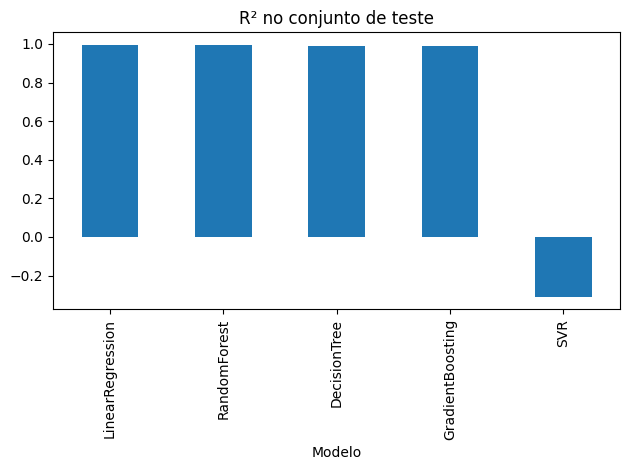

<Figure size 640x480 with 0 Axes>

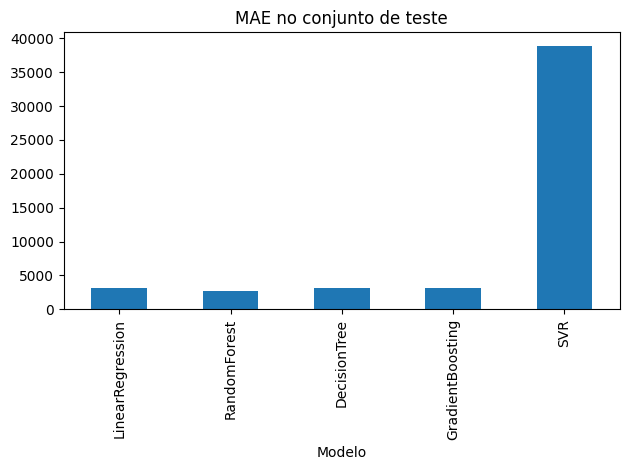

<Figure size 640x480 with 0 Axes>

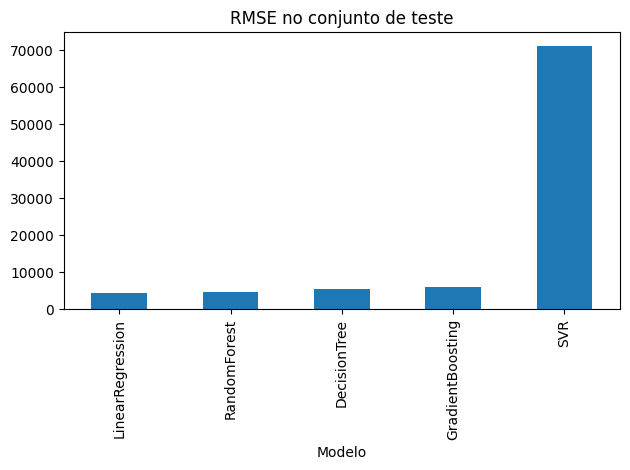

In [10]:

# Gráfico R²
plt.figure()
results_df.plot(x="Modelo", y="Test_R2", kind="bar", legend=False)
plt.title("R² no conjunto de teste")
plt.tight_layout()
plt.show()

# Gráfico MAE
plt.figure()
results_df.plot(x="Modelo", y="Test_MAE", kind="bar", legend=False)
plt.title("MAE no conjunto de teste")
plt.tight_layout()
plt.show()

# Gráfico RMSE
plt.figure()
results_df.plot(x="Modelo", y="Test_RMSE", kind="bar", legend=False)
plt.title("RMSE no conjunto de teste")
plt.tight_layout()
plt.show()



## 7. Melhor modelo: análise rápida e salvamento (`.joblib`)


Melhor modelo (pelo R² de teste): LinearRegression
Hiperparâmetros: {}


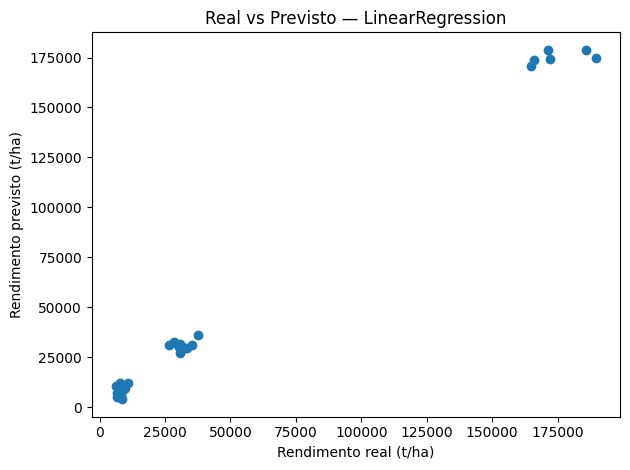

Modelo salvo em: /content/melhor_modelo_LinearRegression.joblib


In [11]:

# Identificar melhor por R² de teste
best_row = results_df.iloc[0]
best_name = best_row["Modelo"]
best_model, best_pred = best_estimators[best_name]

print(f"Melhor modelo (pelo R² de teste): {best_name}")
print("Hiperparâmetros:", best_row["BestParams"])

# Scatter real vs previsto
plt.figure()
plt.scatter(y_test, best_pred)
plt.xlabel("Rendimento real (t/ha)")
plt.ylabel("Rendimento previsto (t/ha)")
plt.title(f"Real vs Previsto — {best_name}")
plt.tight_layout()
plt.show()

# Salvar modelo
model_path = Path(f"melhor_modelo_{best_name}.joblib")
joblib.dump(best_model, model_path)
print(f"Modelo salvo em: {model_path.resolve()}")



## 8. Como usar o modelo salvo para inferência
Exemplo de carregamento e predição para novas condições:


In [12]:

# Exemplo de uso do modelo salvo
# Ajuste o nome do arquivo se o melhor modelo for outro
saved_model_path = sorted(Path('.').glob('melhor_modelo_*.joblib'))[0]
model_loaded = joblib.load(saved_model_path)

# Exemplo de nova amostra (troque pelos seus valores):
novo_exemplo = pd.DataFrame([{
    "Cultura": "Soja",
    "Precipitacao_mm_dia": 5.2,
    "UmidadeEspecifica_gkg": 7.8,
    "UmidadeRelativa_pct": 62.0,
    "Temperatura_C": 24.5
}])

pred = model_loaded.predict(novo_exemplo)[0]
print("Rendimento previsto (t/ha):", pred)


Rendimento previsto (t/ha): -117067.21705593143
